In [10]:
# Warning: usually don't do this kind of inclusion : using *, you 'merge' the namespaces
#          but in this case we actually want to mimic the imports as if they were imported here
from src.setup import *

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

from src import common
from src import host

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

At this point, we expect to have **clean** viral and host data (filtered for missingness, rare variants, hardy-weinberg equilibrium). We also assume that there is a file containing all the individuals (IGM ids) that are in all the datasets (we will use this together with `--keep-fam` command of plink).

We will first filter out the individuals that are missing in any of the three datasets (viral sequencing data, host sequencing data, clinical data) by using a custom function `common.find_individuals`. Then we will run some PCAs and association tests (univariate and multivariate models, i.e. corrected for sex, age, population stratification, ...). Eventually, we'll focus on asian individuals.

## Method

We use a custom `host.plot_plink_pca` function that looks at the plink PCA data and automatically merges a variable of the clinical data.

# Principal component analysis

We want to **exclude the chromosomes 6, X and Y**. We first compute the PCA for all individuals, then for asian people.

## plink PCA computation

We use the `--keep-fam <file>` command to keep individuals that are in all datasets. 

In [6]:
host.run_plink("--pca --keep-fam " + setup.PATH_INTERSECTING_INDIVIDUALS+" --not-chr 0 6 X Y XY",
                file=setup.PATH_HOST_CLEAN_DATA, out=setup.PATH_HOST_CLEAN_DATA,
                extension='eigenvec', log_name='host_pca');

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --pca --keep-fam data/individuals/intersecting_ids --not-chr 0 6 X Y XY '
Log written to 'data/plink/log/host_pca.log'


## All individuals


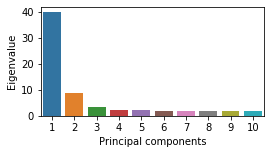

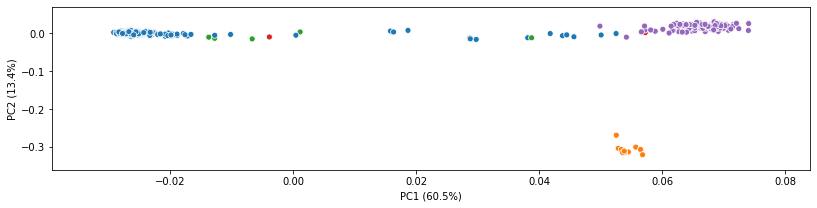

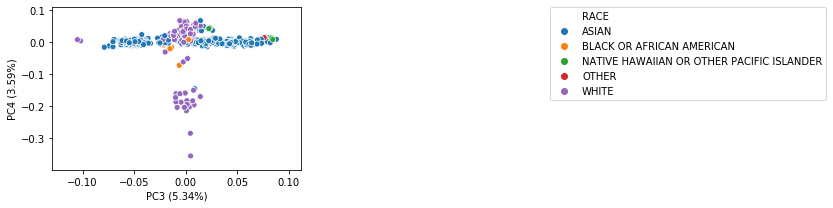

In [8]:
host.plot_plink_pca(setup.PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='RACE',
                   bbox_to_anchor=(2, 1))

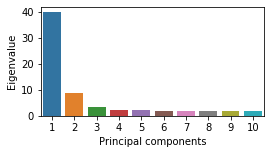

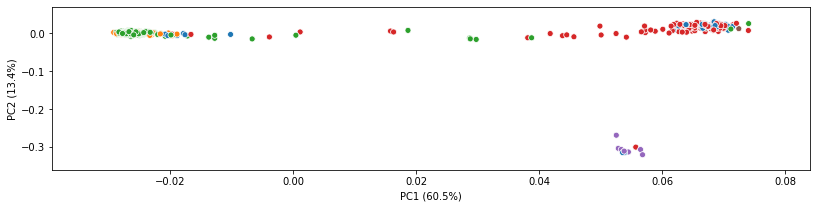

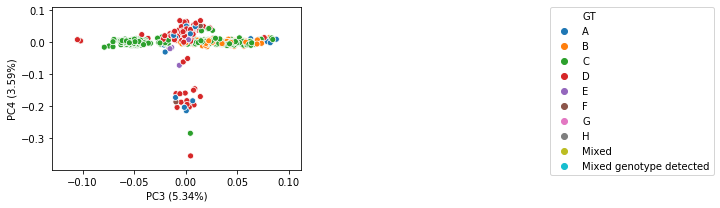

In [9]:
host.plot_plink_pca(setup.PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='GT',
                   bbox_to_anchor=(2, 1))

## Asian individuals

In [16]:
host.run_plink("--pca --keep-fam " + setup.PATH_INDIVIDUALS_ASIAN+" --not-chr 0 6 X Y XY",
                file=setup.PATH_HOST_CLEAN_DATA, out=setup.PATH_HOST_CLEAN_ASIAN,
                extension='eigenvec', log_name='asians_pca', force=True);

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_asian_no_6_x_y --pca --keep-fam data/individuals/asians --not-chr 0 6 X Y XY '
Log written to 'data/plink/log/asians_pca.log'


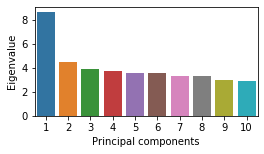

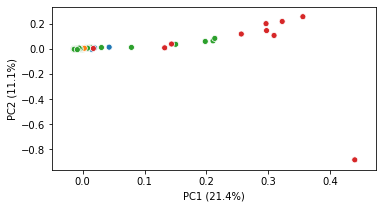

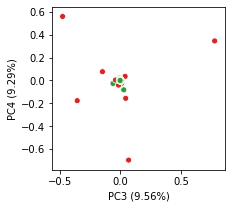

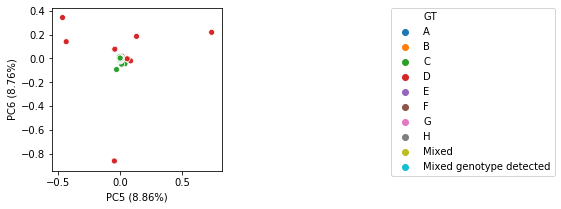

In [20]:
host.plot_plink_pca(setup.PATH_HOST_CLEAN_ASIAN, n_pcs=6, hue_col='GT',
                   bbox_to_anchor=(2, 1))

# Association analyses

Starting from now, all the computations are done with `PATH_WORKING_DATASET` defined in `setup.py` so make sure this variable targets the right dataset.

In [21]:
print("The current working dataset is", setup.PATH_WORKING_DATASET)

The current working dataset is data/plink/host_asian_no_6_x_y


We define a new function that itself uses `run_plink`, but that is optimized for association tests. 

In [ ]:
def 

In [25]:
host.run_plink("--assoc", file=setup.PATH_WORKING_DATASET, out=setup.PATH_WORKING_DATASET,
          extension='assoc', plink2=False)

Running 'plink --bfile data/plink/host_asian_no_6_x_y --out data/plink/host_asian_no_6_x_y --assoc '



('PLINK v1.90b6.10 64-bit (17 Jun 2019)          www.cog-genomics.org/plink/1.9/\n(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3\nLogging to data/plink/host_asian_no_6_x_y.log.\nOptions in effect:\n  --assoc\n  --bfile data/plink/host_asian_no_6_x_y\n  --out data/plink/host_asian_no_6_x_y\n\n64232 MB RAM detected; reserving 32116 MB for main workspace.\n104300 variants loaded from .bim file.\n440 people (0 males, 0 females, 440 ambiguous) loaded from .fam.\nAmbiguous sex IDs written to data/plink/host_asian_no_6_x_y.nosex .\nUsing 1 thread (no multithreaded calculations invoked).\nBefore main variant filters, 440 founders and 0 nonfounders present.\nCalculating allele frequencies... 0%\x08\x081%\x08\x082%\x08\x083%\x08\x084%\x08\x085%\x08\x086%\x08\x087%\x08\x088%\x08\x089%\x08\x0810%\x08\x08\x0811%\x08\x08\x0812%\x08\x08\x0813%\x08\x08\x0814%\x08\x08\x0815%\x08\x08\x0816%\x08\x08\x0817%\x08\x08\x0818%\x08\x08\x0819%\x08\x08\x0820%\x08\x08\x0821%\x08\x08